## Tratamento dos dados

### Importando bibliotecas

In [7]:
import numpy as np
from sklearn.metrics import adjusted_rand_score
import pandas as pd
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [10]:
def inicializacao_matriz_pertinencia(num_amostras, num_clusters):
    matriz_pertinencia = np.random.rand(num_amostras, num_clusters) # gera uma matriz inicial aleatória com valores entre 0 e 1
    matriz_pertinencia = matriz_pertinencia / matriz_pertinencia.sum(axis=1, keepdims=True) # normalização da matriz pra garantir que a soma dos graus dê um
    return matriz_pertinencia
def atualizacao_centroides(dados, matriz_pertinencia, m):
    matriz_pertinencia_m = matriz_pertinencia ** m # preparação dos graus de pertinência
    centroides = np.dot(matriz_pertinencia_m.T, dados) / np.sum(matriz_pertinencia_m.T, axis=1, keepdims=True) # fórmula para o cálculo dos centroides
    return centroides
def atualizacao_matriz_pertinencia(dados, centroides, m):
    # dados[:, np.newaxis] - centroides cria uma matriz de diferenças entre os pontos de dados e os centroides
    # np.linalg.norm(..., axis=2) calcula a norma (distância euclidiana) das diferenças
    # ** 2 para a distância ser a quadrada
    matriz_distancias = np.linalg.norm(dados[:, np.newaxis] - centroides, axis=2) ** 2
    matriz_distancias = np.fmax(matriz_distancias, np.finfo(np.float64).eps) # evita que matriz_distancias seja 0, np.finfo... é o menor número maior que zero aaqui
    matriz_distancias_inversa = 1 / matriz_distancias
    potencia = 1 / (m-1)
    matriz_pertinencia_atualizada = matriz_distancias_inversa ** potencia/ np.sum(matriz_distancias_inversa ** potencia, axis=1, keepdims=True) # fórmula para atualizar os graus de pertinência
    return matriz_pertinencia_atualizada
def fcm(dados, num_clusters, m=2, max_iter=10**6, erro=1e-9):
    num_amostras = dados.shape[0]
    matriz_pertinencia = inicializacao_matriz_pertinencia(num_amostras, num_clusters)
    for _ in range(max_iter): # primeiro critério de parada
        centroides = atualizacao_centroides(dados, matriz_pertinencia, m)
        nova_matriz_pertinencia = atualizacao_matriz_pertinencia(dados, centroides, m)
        if np.linalg.norm(nova_matriz_pertinencia - matriz_pertinencia) < erro: # segundo critério de parada
            break
        matriz_pertinencia = nova_matriz_pertinencia
    return centroides, matriz_pertinencia
def indice_rand(labels, predicted_labels):
    return adjusted_rand_score(labels, predicted_labels)
def simulacao_monte_carlo(dados, labels, num_clusters, num_trials):
    indices_rand = []
    for _ in range(num_trials):
        centroides, matriz_pertinencia = fcm(dados, num_clusters)
        predicted_labels = np.argmax(matriz_pertinencia, axis=1)
        #print(predicted_labels)
        idx_rand = indice_rand(labels, predicted_labels)
        indices_rand.append(idx_rand)
    mean_rand_index = np.mean(indices_rand)
    std_rand_index = np.std(indices_rand)
    return mean_rand_index, std_rand_index

### Geração de dados com ruído

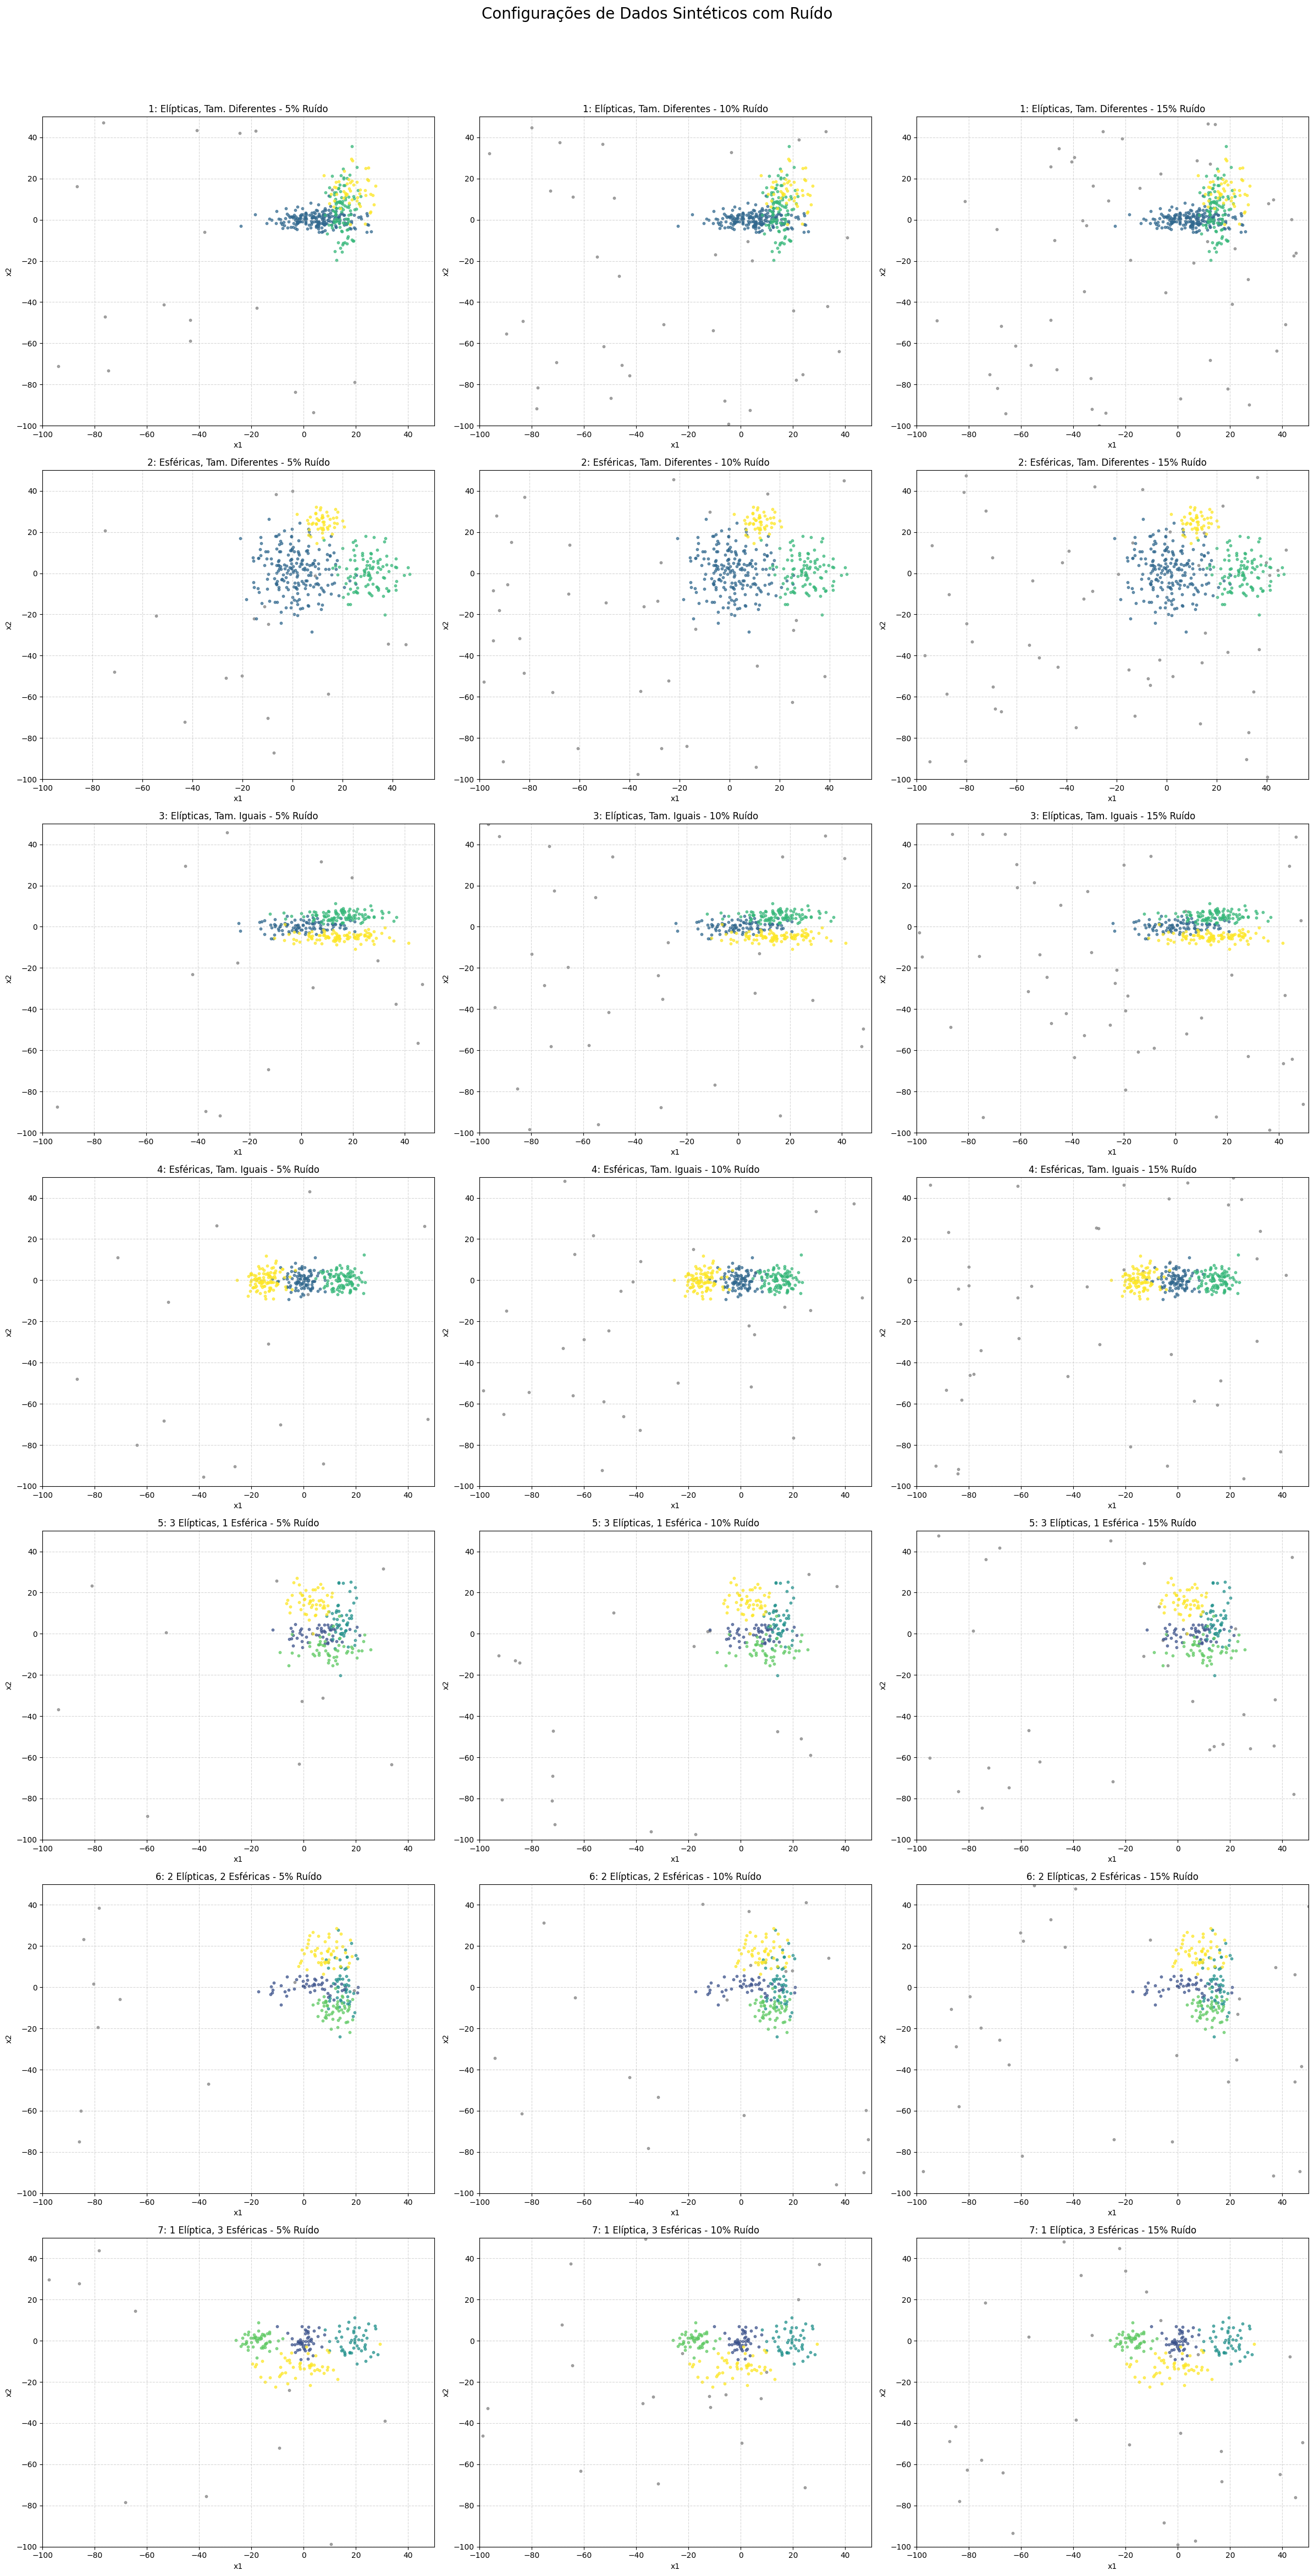

'for config in range(1, 8):\n    for noise in [5,10,15]:\n        df = dados_gerados[config][noise].copy()\n\n        if "config" in df.columns:\n            df.drop("config", axis=1, inplace=True) \n\n        labels = df["class"].values\n        num_clusters = len(df[df[\'class\'] != 0][\'class\'].unique())\n\n        if "class" in df.columns:\n            df.drop("class", axis=1, inplace=True)\n\n        dados = df.to_numpy()\n        num_trials = 100\n\n        media_indice_rand, dp_indice_rand = simulacao_monte_carlo(dados, labels, num_clusters, num_trials)\n        print("-" * 30)\n        print(f"Configuração: {config}, Ruído: {noise}%")\n        print(f"Mean Rand Index: {media_indice_rand:.3f}")\n        print(f"Standard Deviation of Rand Index: {dp_indice_rand:.3f}")'

In [ ]:
def gerar_configuracao(mu_list, sigma_list, tamanhos, config_id):
    dfs = []
    for i, (mu, sigma2, n) in enumerate(zip(mu_list, sigma_list, tamanhos)):
        Sigma = np.diag(sigma2)
        data = np.random.multivariate_normal(mu, Sigma, n)
        df = pd.DataFrame(data, columns=["x1", "x2"])
        df["class"] = i + 1
        dfs.append(df)
    df_config = pd.concat(dfs, ignore_index=True)
    df_config["config"] = config_id
    return df_config

def adicionar_ruido(df_original, porcentagem, min_val, max_val):
    n_original = len(df_original)
    n_ruido = int(n_original * porcentagem)

    df_com_ruido = df_original.copy()

    if n_ruido == 0:
        return df_com_ruido

    ruido_x1 = np.random.uniform(min_val, max_val, n_ruido)
    ruido_x2 = np.random.uniform(min_val, max_val, n_ruido)

    df_ruido = pd.DataFrame({'x1': ruido_x1, 'x2': ruido_x2})
    df_ruido['class'] = 0 # Classe 0 para ruído
    df_ruido['config'] = df_original['config'].iloc[0]

    return pd.concat([df_com_ruido, df_ruido], ignore_index=True)

np.random.seed(42)

config_params = [
    {'mu': [[5, 0], [15, 5], [18, 14]], 'sigma2': [[81, 9], [9, 100], [25, 36]], 'n': [200, 100, 50], 'desc': "1: Elípticas, Tam. Diferentes"},
    {'mu': [[0, 0], [30, 0], [12, 25]], 'sigma2': [[100, 100], [49, 49], [16, 16]], 'n': [200, 100, 50], 'desc': "2: Esféricas, Tam. Diferentes"},
    {'mu': [[0, 0], [15, 5], [15, -5]], 'sigma2': [[100, 4], [100, 4], [100, 4]], 'n': [100, 100, 100], 'desc': "3: Elípticas, Tam. Iguais"},
    {'mu': [[0, 0], [15, 0], [-15, 0]], 'sigma2': [[16, 16], [16, 16], [16, 16]], 'n': [100, 100, 100], 'desc': "4: Esféricas, Tam. Iguais"},
    {'mu': [[5, 0], [15, 5], [10, -7], [3, 15]], 'sigma2': [[81, 9], [9, 100], [49, 16], [25, 25]], 'n': [50, 50, 50, 50], 'desc': "5: 3 Elípticas, 1 Esférica"},
    {'mu': [[5, 0], [15, 5], [12, -12], [7, 17]], 'sigma2': [[81, 9], [9, 100], [16, 16], [25, 25]], 'n': [50, 50, 50, 50], 'desc': "6: 2 Elípticas, 2 Esféricas"},
    {'mu': [[0, 0], [18, 0], [-18, 0], [0, -12]], 'sigma2': [[12, 12], [20, 20], [16, 16], [81, 20]], 'n': [50, 50, 50, 50], 'desc': "7: 1 Elíptica, 3 Esféricas"}
]

dados_base = {}
for i, params in enumerate(config_params):
    config_id = i + 1
    dados_base[config_id] = gerar_configuracao(params['mu'], params['sigma2'], params['n'], config_id=config_id)

porcentagens_ruido = [0.05, 0.10, 0.15]
ruido_min, ruido_max = -100, 50
dados_gerados = {}

fig, axes = plt.subplots(7, 3, figsize=(24, 48))
fig.suptitle('Configurações de Dados Sintéticos com Ruído', fontsize=20, y=1.005)

for i, params in enumerate(config_params):
    config_id = i + 1
    df_base_original = dados_base[config_id] 
    dados_gerados[config_id] = {}

    for j, p_ruido in enumerate(porcentagens_ruido):
        p_ruido_int = int(p_ruido * 100)
        df_ruidoso = adicionar_ruido(df_base_original, p_ruido, ruido_min, ruido_max)
        dados_gerados[config_id][p_ruido_int] = df_ruidoso

        ax = axes[i, j]
        cores = plt.cm.viridis(np.linspace(0, 1, len(df_ruidoso['class'].unique())))
        cor_map = {cls: cores[k] for k, cls in enumerate(sorted(df_ruidoso['class'].unique()))}
        cor_map[0] = 'gray'

        for cls in sorted(df_ruidoso['class'].unique()):
            df_subset = df_ruidoso[df_ruidoso['class'] == cls]
            ax.scatter(df_subset['x1'], df_subset['x2'],
                       label=f'Classe {cls}' if cls != 0 else 'Ruído',
                       color=cor_map[cls], s=10, alpha=0.7)

        x_min_data = df_base_original['x1'].min() - 10
        x_max_data = df_base_original['x1'].max() + 10
        y_min_data = df_base_original['x2'].min() - 10
        y_max_data = df_base_original['x2'].max() + 10
        ax.set_xlim(min(ruido_min, x_min_data), max(ruido_max, x_max_data))
        ax.set_ylim(min(ruido_min, y_min_data), max(ruido_max, y_max_data))
        ax.set_title(f"{params['desc']} - {p_ruido_int}% Ruído")
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

for config in range(1, 8):
    for noise in [5,10,15]:
        df = dados_gerados[config][noise].copy()
        
        if "config" in df.columns:
            df.drop("config", axis=1, inplace=True) 
        
        labels = df["class"].values
        num_clusters = len(df[df['class'] != 0]['class'].unique())
        
        if "class" in df.columns:
            df.drop("class", axis=1, inplace=True)
            
        dados = df.to_numpy()
        num_trials = 100
        
        media_indice_rand, dp_indice_rand = simulacao_monte_carlo(dados, labels, num_clusters, num_trials)
        print("-" * 30)
        print(f"Configuração: {config}, Ruído: {noise}%")
        print(f"Mean Rand Index: {media_indice_rand:.3f}")
        print(f"Standard Deviation of Rand Index: {dp_indice_rand:.3f}")

A melhora observada na Configuração 3 é provavelmente um sinal da extrema dificuldade que o FCM enfrenta com esses dados elípticos e sobrepostos. Não é um fenômeno normal, mas sim algo que pode surgir quando um algoritmo está funcionando mal, onde pequenas perturbações (ruído) podem levar a resultados imprevisíveis, mas ainda assim ruins

In [11]:
def gerar_configuracao(mu_list, sigma_list, tamanhos, config_id):
    dfs = []
    for i, (mu, sigma2, n) in enumerate(zip(mu_list, sigma_list, tamanhos)):
        Sigma = np.diag(sigma2)
        data = np.random.multivariate_normal(mu, Sigma, n)
        df = pd.DataFrame(data, columns=["x1", "x2"])
        df["class"] = i + 1
        dfs.append(df)
    df_config = pd.concat(dfs, ignore_index=True)
    df_config["config"] = config_id
    return df_config

np.random.seed(42)  # reprodutibilidade

# Configuração 1
mu_1 = [[5, 0], [15, 5], [18, 14]]
sigma2_1 = [[81, 9], [9, 100], [25, 36]]
n1 = [200, 100, 50]
df1 = gerar_configuracao(mu_1, sigma2_1, n1, config_id=1)
l1 = "Classes elípticas de tamanhos diferentes"

# Configuração 2
mu_2 = [[0, 0], [30, 0], [12, 25]]
sigma2_2 = [[100, 100], [49, 49], [16, 16]]
n2 = [200, 100, 50]
df2 = gerar_configuracao(mu_2, sigma2_2, n2, config_id=2)
l2 = "Classes esféricas de tamanhos diferentes"

# Configuração 3
mu_3 = [[0, 0], [15, 5], [15, -5]]
sigma2_3 = [[100, 4], [100, 4], [100, 4]]
n3 = [100, 100, 100]
df3 = gerar_configuracao(mu_3, sigma2_3, n3, config_id=3)
l3 = "Classes elípticas de tamanhos iguais"

# Configuração 4
mu_4 = [[0, 0], [15, 0], [-15, 0]]
sigma2_4 = [[16, 16], [16, 16], [16, 16]]
n4 = [100, 100, 100]
df4 = gerar_configuracao(mu_4, sigma2_4, n4, config_id=4)
l4 = "Classes esféricas de tamanhos iguais"

# Configuração 5
mu_5 = [[5, 0], [15, 5], [10, -7], [3, 15]]
sigma2_5 = [[81, 9], [9, 100], [49, 16], [25, 25]]
n5 = [50, 50, 50, 50]
df5 = gerar_configuracao(mu_5, sigma2_5, n5, config_id=5)
l5 = "3 classes elípticas e 1 esférica"

# Configuração 6
mu_6 = [[5, 0], [15, 5], [12, -12], [7, 17]]
sigma2_6 = [[81, 9], [9, 100], [16, 16], [25, 25]]
n6 = [50, 50, 50, 50]
df6 = gerar_configuracao(mu_6, sigma2_6, n6, config_id=6)
l6 = "2 classes elípticas e 2 esféricas"

# Configuração 7
mu_7 = [[0, 0], [18, 0], [-18, 0], [0, -12]]
sigma2_7 = [[12, 12], [20, 20], [16, 16], [81, 20]]
n7 = [50, 50, 50, 50]
df7 = gerar_configuracao(mu_7, sigma2_7, n7, config_id=7)
l7 = "1 classe elíptica e 3 esféricas"

In [5]:
for df in [df1, df2, df3, df4, df5, df6, df7]:
    np.random.seed(42)  # reprodutibilidade
    df.drop("config", axis=1, inplace=True)  # remove a coluna de configuração
    labels = df["class"].values
    num_clusters = len(df[df['class'] != 0]['class'].unique())  # número de clusters, excluindo o ruído
    df.drop("class", axis=1, inplace=True)  # remove a coluna de classe
    dados = df.to_numpy()
    num_trials = 100
    media_indice_rand, dp_indice_rand = simulacao_monte_carlo(dados, labels, num_clusters, num_trials)
    print(f"Mean Rand Index: {media_indice_rand:.3f}")
    print(f"Standard Deviation of Rand Index: {dp_indice_rand:.3f}")

Mean Rand Index: 0.294
Standard Deviation of Rand Index: 0.000
Mean Rand Index: 0.613
Standard Deviation of Rand Index: 0.000
Mean Rand Index: 0.129
Standard Deviation of Rand Index: 0.000
Mean Rand Index: 0.847
Standard Deviation of Rand Index: 0.000
Mean Rand Index: 0.429
Standard Deviation of Rand Index: 0.000
Mean Rand Index: 0.481
Standard Deviation of Rand Index: 0.000
Mean Rand Index: 0.765
Standard Deviation of Rand Index: 0.000


## Dados com outliers

In [12]:
np.random.seed(42)

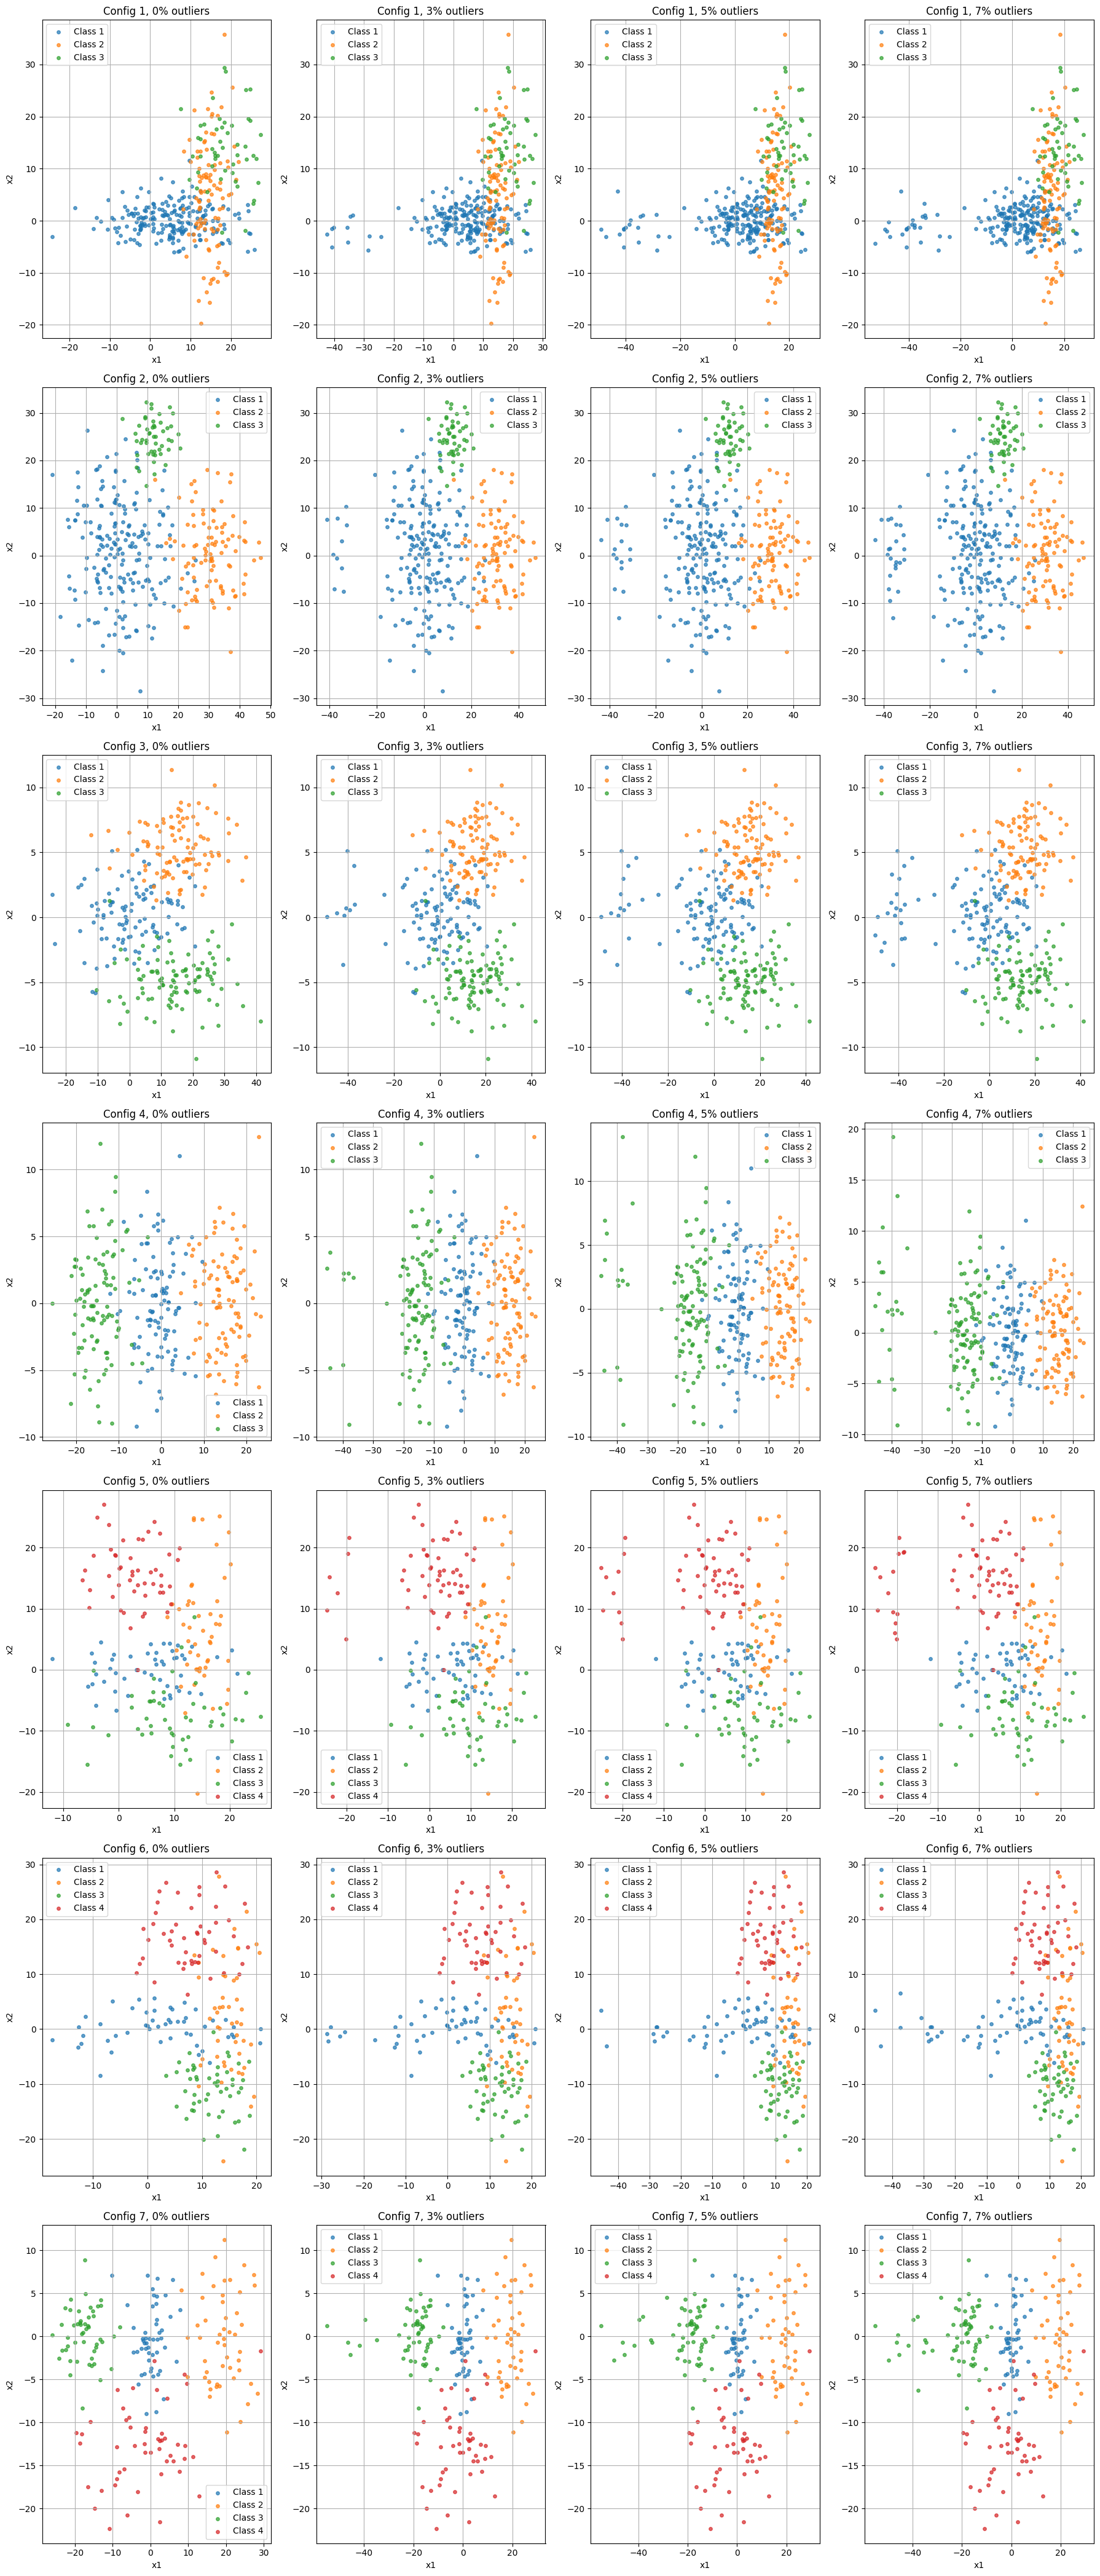

In [13]:
def adicionar_N_outliers_laterais(df_para_modificar: pd.DataFrame,
                                  df_original_referencia: pd.DataFrame,
                                  n_outliers_para_adicionar: int,
                                  cluster_id_alvo: int,
                                  distancia_x1_outliers: float,
                                  dispersao_x1_outliers: float = 1.0,
                                  dispersao_x2_outliers: float = 1.0) -> pd.DataFrame:
    
    if n_outliers_para_adicionar <= 0:
        return df_para_modificar.copy()

    # Pega os dados do cluster alvo DO DATAFRAME ORIGINAL para usar como referência
    dados_cluster_ref = df_original_referencia[df_original_referencia['class'] == cluster_id_alvo]
    min_x1_cluster = dados_cluster_ref['x1'].min()
    media_x2_cluster = dados_cluster_ref['x2'].mean()
    centro_x1_outliers = min_x1_cluster - distancia_x1_outliers

    # Gera apenas o número N de novos outliers
    outliers_x1 = np.random.normal(loc=centro_x1_outliers, scale=dispersao_x1_outliers, size=n_outliers_para_adicionar)
    outliers_x2 = np.random.normal(loc=media_x2_cluster, scale=dispersao_x2_outliers, size=n_outliers_para_adicionar)

    df_novos_outliers = pd.DataFrame({'x1': outliers_x1, 'x2': outliers_x2})
    df_novos_outliers['class'] = cluster_id_alvo
    
    config_val = df_original_referencia['config'].iloc[0]
    df_novos_outliers['config'] = config_val
    
    # Concatena os novos outliers ao dataframe que já está sendo modificado
    df_final = pd.concat([df_para_modificar, df_novos_outliers], ignore_index=True)
    
    return df_final

lista_dfs_originais = [df1, df2, df3, df4, df5, df6, df7]

# 3. NOVA LÓGICA CUMULATIVA PARA ADICIONAR OUTLIERS

configuracoes_meta = [
    {'config_id': 1, 'outlier_target_cluster': 1, 'outlier_dispersao_x1': 7, 'outlier_dispersao_x2': 3},
    {'config_id': 2, 'outlier_target_cluster': 1, 'outlier_dispersao_x1': 3, 'outlier_dispersao_x2': 7},
    {'config_id': 3, 'outlier_target_cluster': 1, 'outlier_dispersao_x1': 7, 'outlier_dispersao_x2': 2},
    {'config_id': 4, 'outlier_target_cluster': 3, 'outlier_dispersao_x1': 3, 'outlier_dispersao_x2': 7},
    {'config_id': 5, 'outlier_target_cluster': 4, 'outlier_dispersao_x1': 3, 'outlier_dispersao_x2': 7},
    {'config_id': 6, 'outlier_target_cluster': 1, 'outlier_dispersao_x1': 7, 'outlier_dispersao_x2': 3},
    {'config_id': 7, 'outlier_target_cluster': 3, 'outlier_dispersao_x1': 7, 'outlier_dispersao_x2': 2}
]

# Garante que as porcentagens estão em ordem crescente
porcentagens_outlier = sorted([0, 0.03, 0.05, 0.07])
distancia_x1_para_outliers = 15

datasets_outliers = {}

for config_meta in configuracoes_meta:
    config_id = config_meta['config_id']
    df_original = lista_dfs_originais[config_id - 1]
    
    n_pontos_original = len(df_original)
    
    # df_acumulado guarda o resultado da etapa anterior
    df_acumulado = df_original.copy()
    datasets_outliers[(config_id, 0.0)] = df_acumulado

    
    # Itera sobre as porcentagens para calcular quantos outliers adicionar a cada passo
    for i in range(1, len(porcentagens_outlier)):
        p_atual = porcentagens_outlier[i]
        p_anterior = porcentagens_outlier[i-1]
        
        # Calcula o número total de outliers que deveríamos ter neste passo
        n_outliers_alvo = int(n_pontos_original * p_atual)
        
        # Calcula quantos outliers já existem no dataframe acumulado
        n_outliers_existentes = len(df_acumulado) - n_pontos_original
        
        # A diferença é o número de novos outliers a adicionar
        n_para_adicionar = n_outliers_alvo - n_outliers_existentes

        # Adiciona o número calculado de outliers ao dataframe já modificado
        df_acumulado = adicionar_N_outliers_laterais(
            df_para_modificar=df_acumulado,
            df_original_referencia=df_original, # Importante usar o original como referência
            n_outliers_para_adicionar=n_para_adicionar,
            cluster_id_alvo=config_meta['outlier_target_cluster'],
            distancia_x1_outliers=distancia_x1_para_outliers,
            dispersao_x1_outliers=config_meta['outlier_dispersao_x1'],
            dispersao_x2_outliers=config_meta['outlier_dispersao_x2']
        )
        datasets_outliers[(config_id, p_atual)] = df_acumulado


num_configs = len(configuracoes_meta)
num_outlier_porc = len(porcentagens_outlier)

fig, axes = plt.subplots(num_configs, num_outlier_porc, figsize=(18, 42), squeeze=False)

for i, config_meta in enumerate(configuracoes_meta):
    for j, percent_outliers in enumerate(porcentagens_outlier):
        ax = axes[i, j]
        config_id = config_meta['config_id']
        
        df_to_plot = datasets_outliers.get((config_id, percent_outliers))

        if df_to_plot is not None:
            for classe, dados_classe in df_to_plot.groupby('class'):
                ax.scatter(dados_classe['x1'], dados_classe['x2'], label=f'Class {classe}', s=15, alpha=0.7)
            
            ax.set_title(f'Config {config_id}, {int(percent_outliers*100)}% outliers')
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            ax.legend()
            ax.grid(True)

plt.tight_layout()
plt.show()

In [14]:
np.random.seed(42)

for config in range(1, num_configs + 1):
    for outlier in porcentagens_outlier:
        df = datasets_outliers.get((config, outlier)).copy()
        #print(df)
        df.drop("config", axis=1, inplace=True) 
        
        labels = df["class"].values
        num_clusters = len(df['class'].unique())
        
        df.drop("class", axis=1, inplace=True)
        
        dados = df.to_numpy()
        num_trials = 100
        
        media_indice_rand, dp_indice_rand = simulacao_monte_carlo(dados, labels, num_clusters, num_trials)
        print("-" * 30)
        print(f"Configuração: {config}, Outlier: {int(outlier * 100)}%")
        print(f"Mean Rand Index: {media_indice_rand:.3f}")
        print(f"Standard Deviation of Rand Index: {dp_indice_rand:.3f}")

------------------------------
Configuração: 1, Outlier: 0%
Mean Rand Index: 0.294
Standard Deviation of Rand Index: 0.000
------------------------------
Configuração: 1, Outlier: 3%
Mean Rand Index: 0.265
Standard Deviation of Rand Index: 0.000
------------------------------
Configuração: 1, Outlier: 5%
Mean Rand Index: 0.260
Standard Deviation of Rand Index: 0.000
------------------------------
Configuração: 1, Outlier: 7%
Mean Rand Index: 0.236
Standard Deviation of Rand Index: 0.000
------------------------------
Configuração: 2, Outlier: 0%
Mean Rand Index: 0.613
Standard Deviation of Rand Index: 0.000
------------------------------
Configuração: 2, Outlier: 3%
Mean Rand Index: 0.582
Standard Deviation of Rand Index: 0.000
------------------------------
Configuração: 2, Outlier: 5%
Mean Rand Index: 0.582
Standard Deviation of Rand Index: 0.000
------------------------------
Configuração: 2, Outlier: 7%
Mean Rand Index: 0.528
Standard Deviation of Rand Index: 0.000
----------------